In [122]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import pypfopt

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

import quantstats as qs

pd.options.plotting.backend = "plotly"

# Guide

This presents a proof of concept for how to systematize parts of our portfolio allocation methodology going forward

The intent is to lay out a concise framework on how to quantitatively process both empirical data and discretionary views into a portfolio model that ultimately provides us with optimal portfolio weights. 

This model is kept intentionally simple. Each of these steps contains a set of non-trivial assumptions that that would need to be revisited in detail were we to follow through on this approach (see section at end).

General structure:

#### 1. Model Inputs ####
- Empirical Distribution of risk assets in our universe, for example Indices, Funds, Equities, etc. **(priors)**
&rarr; For this example, I have selected a few 'proxy' assets to broadly mimick how we think about portfolio construction, namely:
    * Offense &rarr; SPX Index
    * Defense &rarr; EHFI451 Index (Long Vol Index) & EHFI453 Index (Tail Risk Index)
    * Cash &rarr; DXY Curncy & XAU Curncy


- Discretionary Views on risk assets (relative or absolute), for example GIP model, upper/lower return bounds for asset, asset class X will outperform asset class Y, etc.
&rarr; For this example, I'm using a simplified version of Hedgeyes GIP model to classify historical timeseries into one of the 4 quadrants. These regimes are determined by two factors only, namely the rate of change in QoQ GDP and QoQ CPI.
I'm then using these regimes to estimate regime-conditional return distributions for each asset, essentially making expected returns for each asset dependent on the (expected) regime.

- A priori portfolio constraints, for example need Equities exposure > 10 % at all times, Gold never < 40 %
&rarr; In this case, I'm ommitting any additional discretionary views.

#### 2. Construct posterior asset distributions ####


#### 3. Solve for optimal portfolio weights according to pre-defined objective function ####
The traditional metric to optimize for is mean-variance, which I'm also using here for ilustrative purposes
Other objective functions may include max return, min risk, max risk adj return ratio, max utility, mean downside variance, etc. 

This results in portfolio weights optimized for selected objective.
&rarr; Here we're solving for a max sharpe ratio

#### 4. Backtesting ####



For this purpose, I have selected a few 'proxy' assets to broadly mimick how we think about portfolio construction, namely:
- Offense &rarr; SPX Index
- Defense &rarr; EHFI451 Index (Long Vol Index) & EHFI453 Index (Tail Risk Index)
- Cash &rarr; DXY Curncy & XAU Curncy



## Key Considerations

#### 1. Model Inputs ####
- Two major challenges
* 1. Proxy returns:
* 2. Sample size: 

#### 2. Posterior Distributions ####

#### 3. Optimization ####

#### 3. Backtesting & Stress-testing ####

In [2]:
assets = ['SPX Index','DXY Curncy','EHFI451 Index','EHFI453 Index','XAU Curncy']

data_df = pd.read_csv('.\data\poc_data.csv')
data_df.columns = ['Date'] + data_df.columns.tolist()[1:]
data_df['Date'] = pd.to_datetime(data_df.Date)
print(data_df.shape)
data_df = data_df.dropna(how='any')
data_df = data_df.set_index('Date')

print(data_df.shape)
data_df.tail()

(385, 10)
(178, 9)


C:\Users\InvestmentsInterns\AppData\Local\Temp\ipykernel_23200\254686824.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data_df['Date'] = pd.to_datetime(data_df.Date)


,SPX Index,NDX Index,XAU Curncy,DXY Curncy,EHFI251 Index,EHFI451 Index,EHFI453 Index,EHPIUS Index,GDP CQOQ Index
Date,,,,,,,,,
2022-05-31,4132.15,12642.10,1845.97,101.752,618.6914,198.99,62.37,7.97,-1.6
2022-06-30,3785.38,11503.72,1809.95,104.685,601.5739,205.17,64.71,8.67,-0.6
2022-07-29,4130.29,12947.97,1765.94,105.903,611.0150,202.77,63.38,8.67,-0.6
2022-08-31,3955.00,12272.03,1716.22,108.700,611.7484,205.05,64.35,8.67,-0.6
2022-09-30,3585.62,10971.22,1660.61,112.117,598.4518,213.21,66.23,8.33,-0.6


In [3]:
# Classify regimes
# Resample to quarterly data just to classify regimes
qdata_df = data_df[['EHPIUS Index','GDP CQOQ Index']].resample('Q', convention='start').asfreq()
print(qdata_df.shape)

# Assign regimes
feat_df = qdata_df.copy()
feat_df['EHPIUS Index'] = feat_df['EHPIUS Index'].diff(1)
feat_df = feat_df.dropna()
feat_df['regime'] = np.nan

feat_df['regime'] = np.where((feat_df['EHPIUS Index']<0) & (feat_df['GDP CQOQ Index']>0),"Quad 1", 0)
feat_df['regime'] = np.where((feat_df['EHPIUS Index']>0) & (feat_df['GDP CQOQ Index']>0),"Quad 2", feat_df['regime'])
feat_df['regime'] = np.where((feat_df['EHPIUS Index']>0) & (feat_df['GDP CQOQ Index']<0),"Quad 3", feat_df['regime'])
feat_df['regime'] = np.where((feat_df['EHPIUS Index']<0) & (feat_df['GDP CQOQ Index']<0),"Quad 4", feat_df['regime'])

feat_df.tail()

(60, 2)


,EHPIUS Index,GDP CQOQ Index,regime
Date,,,
2021-09-30,0.50,2.7,Quad 2
2021-12-31,1.30,7.0,Quad 2
2022-03-31,1.30,-1.6,Quad 3
2022-06-30,0.70,-0.6,Quad 3
2022-09-30,-0.34,-0.6,Quad 4


In [5]:
# Label monthly data (regime)
data_df1 = data_df[['SPX Index','DXY Curncy','EHFI451 Index','EHFI453 Index','XAU Curncy']]

data_df2 = data_df1.merge(feat_df[['regime']], 'left', left_index=True, right_index=True)
data_df2['regime'] = data_df2['regime'].ffill()
print(data_df2.shape)

data_df3 = data_df2.dropna(subset=['regime'])
print(data_df3.shape)

(178, 6)
(175, 6)


In [6]:
data_df3.tail()

,SPX Index,DXY Curncy,EHFI451 Index,EHFI453 Index,XAU Curncy,regime
Date,,,,,,
2022-05-31,4132.15,101.752,198.99,62.37,1845.97,Quad 3
2022-06-30,3785.38,104.685,205.17,64.71,1809.95,Quad 3
2022-07-29,4130.29,105.903,202.77,63.38,1765.94,Quad 3
2022-08-31,3955.00,108.700,205.05,64.35,1716.22,Quad 3
2022-09-30,3585.62,112.117,213.21,66.23,1660.61,Quad 4


In [51]:
# Returns df (monthly)
ret_df = data_df3.copy()
ret_df[assets] = ret_df[assets].pct_change()
ret_df = ret_df.dropna()

# Quick inspection
ret_df.describe()
ret_df.regime.value_counts()

Quad 2    60
Quad 1    54
Quad 3    47
Quad 4    13
Name: regime, dtype: int64

In [50]:
ret_df[ret_df.regime == 'Quad 4'].drop(columns=['regime']).mean() * 12

SPX Index        0.187117
DXY Curncy      -0.117718
EHFI451 Index    0.158197
EHFI453 Index   -0.046222
XAU Curncy       0.245882
dtype: float64

In [64]:
# Estimate distributions conditional on regime
def sumstats(df, regime):
    mu = mean_historical_return(df, returns_data=True, frequency=12, compounding=False)
    S = CovarianceShrinkage(df,  returns_data=True, frequency=12).ledoit_wolf()
    return dict(regime=regime, mean=mu, cov=S)


li_ss = [sumstats(group.drop(columns=['regime']), name) for name, group in ret_df.groupby('regime')]
len(li_ss)

4

In [251]:
li_ss[0]

{'regime': 'Quad 1',
 'mean': SPX Index        0.126480
 DXY Curncy       0.014645
 EHFI451 Index   -0.005613
 EHFI453 Index   -0.066499
 XAU Curncy       0.128755
 dtype: float64,
 'cov':                SPX Index  DXY Curncy  EHFI451 Index  EHFI453 Index  XAU Curncy
 SPX Index       0.014908   -0.003530      -0.003345      -0.001702   -0.000747
 DXY Curncy     -0.003530    0.006212       0.000303       0.001099   -0.001429
 EHFI451 Index  -0.003345    0.000303       0.004388       0.001017    0.002598
 EHFI453 Index  -0.001702    0.001099       0.001017       0.004717    0.002451
 XAU Curncy     -0.000747   -0.001429       0.002598       0.002451    0.016307}

In [67]:
# Plot asset returns conditional on regime
fig_dic = {}

for a in assets: 
    fig = px.histogram(ret_df, x=a, color="regime",
                   marginal="box", # or violin, rug
                   nbins=30,
                   )
    fig.update_layout(height=500, paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
    fig_dic[a] = fig
    
fig.show()

In [68]:
fig_dic['SPX Index']

In [69]:
# Optimization conditional on regime
def eff_front(dic):
    ef = EfficientFrontier(dic['mean'], dic['cov'])
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    return dict(regime=dic['regime'], ef=ef, weights=cleaned_weights)

li_eff = [eff_front(i) for i in li_ss]
len(li_eff)

4

In [250]:
li_eff[0]['ef'].portfolio_performance(verbose=True)

Expected annual return: 9.8%
Annual volatility: 5.9%
Sharpe Ratio: 1.32


(0.09760377692579476, 0.058727431651669736, 1.321422966120609)

In [89]:
# Create regime weighting map
rw_df = pd.DataFrame([dict(regime=i['regime'], **i['weights']) for i in li_eff])
rw_df = rw_df.set_index('regime')
rw_df

,SPX Index,DXY Curncy,EHFI451 Index,EHFI453 Index,XAU Curncy
regime,,,,,
Quad 1,0.39711,0.26508,0.00000,0.0,0.33782
Quad 2,0.27739,0.44164,0.00000,0.0,0.28097
Quad 3,0.18706,0.41095,0.40199,0.0,0.00000
Quad 4,0.20973,0.00000,0.44985,0.0,0.34042


In [158]:
# Backtest cond allocations
ts_regimes = ret_df[['regime']]
ts_weights = rw_df.merge(ret_df[['regime']], how='right', left_index=True, right_on='regime').drop(columns=['regime'])

# Porfolio weighted returns
port_rets = ret_df.copy().drop(columns=['regime'])
print(ts_weights.shape == port_rets.shape)
port_rets['Portfolio'] = (port_rets * ts_weights).sum(axis=1)

# Cum rets
port_crets = port_rets.add(1).cumprod()
# port_rets['cret_port'] = port_rets.ret_port.add(1).cumprod()

True


In [159]:
port_crets.plot()

In [195]:
ts_regimes1 = ts_regimes.copy()
ts_regimes1['regime_start'] = ts_regimes[ts_regimes.regime != ts_regimes.regime.shift(1)]
ts_regimes1['regime_end'] = ts_regimes[ts_regimes.regime != ts_regimes.regime.shift(-1)]

In [239]:
regime_li = []

for i in list(zip(ts_regimes[ts_regimes.regime != ts_regimes.regime.shift(1)].reset_index().to_records(), \
    ts_regimes[ts_regimes.regime != ts_regimes.regime.shift(-1)].reset_index().to_records())):
    regime_li += [(i[0][2], pd.Timestamp(i[0][1]).replace(day=1).strftime('%Y-%m-%d'), i[1][1])]


fillcolors_regimes = {
    'Quad 1': "green",
    'Quad 2': "blue",
    'Quad 3': "yellow",
    'Quad 4': "LightSalmon",
}

In [242]:
# Create figure w/ regimes
fig = port_crets.plot()

for i in regime_li:
    start = i[1]
    end = i[2].astype(str)[:10]

    # Add shape regions
    fig.add_vrect(
        x0=start, x1=end,
        fillcolor=fillcolors_regimes[i[0]], opacity=0.2,
        layer="below", line_width=0,
    )

fig.show()

In [246]:
# Returns regime cond
fig = ret_df.drop(columns=['regime']).plot.bar()

for i in regime_li:
    start = i[1]
    end = i[2].astype(str)[:10]

    # Add shape regions
    fig.add_vrect(
        x0=start, x1=end,
        fillcolor=fillcolors_regimes[i[0]], opacity=0.2,
        layer="below", line_width=0,
    )

fig.show()

In [247]:
fig = feat_df[['EHPIUS Index','GDP CQOQ Index']].plot()

for i in regime_li:
    start = i[1]
    end = i[2].astype(str)[:10]

    # Add shape regions
    fig.add_vrect(
        x0=start, x1=end,
        fillcolor=fillcolors_regimes[i[0]], opacity=0.2,
        layer="below", line_width=0,
    )

fig.show()

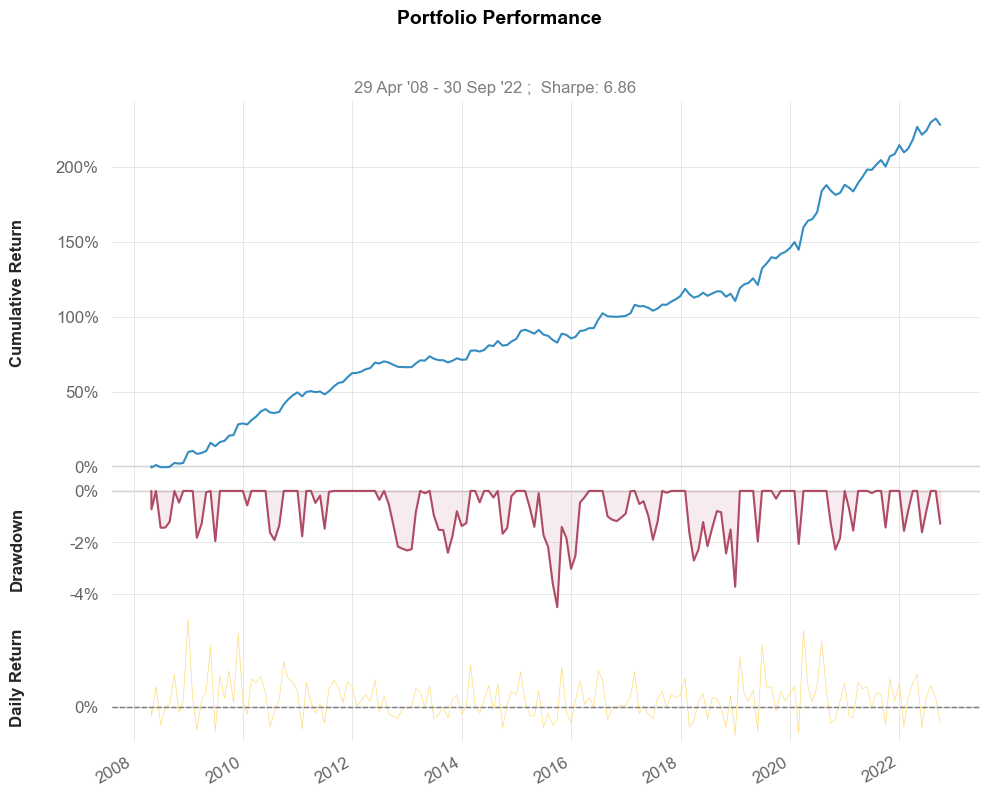

In [129]:
# Tearsheet report 
qs.plots.snapshot(port_rets.Portfolio, title='Portfolio Performance')

In [ ]:
# port_rets.index = port_rets.index.tz_localize('America/New_York').tz_convert('America/New_York')
qs.reports.html(port_rets.Portfolio, "SPY")

In [147]:
port_rets.index

DatetimeIndex(['2008-04-30 00:00:00-04:00', '2008-05-30 00:00:00-04:00',
               '2008-06-30 00:00:00-04:00', '2008-07-31 00:00:00-04:00',
               '2008-08-29 00:00:00-04:00', '2008-09-30 00:00:00-04:00',
               '2008-10-31 00:00:00-04:00', '2008-11-28 00:00:00-05:00',
               '2008-12-31 00:00:00-05:00', '2009-01-30 00:00:00-05:00',
               ...
               '2021-12-31 00:00:00-05:00', '2022-01-31 00:00:00-05:00',
               '2022-02-28 00:00:00-05:00', '2022-03-31 00:00:00-04:00',
               '2022-04-29 00:00:00-04:00', '2022-05-31 00:00:00-04:00',
               '2022-06-30 00:00:00-04:00', '2022-07-29 00:00:00-04:00',
               '2022-08-31 00:00:00-04:00', '2022-09-30 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=174, freq=None)

In [148]:
port_rets.index.dtype

datetime64[ns, America/New_York]

In [157]:
ts_weights.plot()